In [3]:
import pickle

with open('reddit_graph.pkl', 'rb') as f:
    G = pickle.load(f)
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Loaded graph with 35776 nodes and 137821 edges.


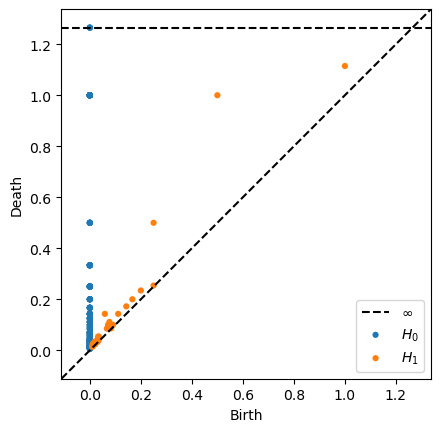

Top persistent H0 features (birth, death, persistence):
1: Birth=0.000, Death=inf, Persistence=inf
2: Birth=0.000, Death=inf, Persistence=inf
3: Birth=0.000, Death=inf, Persistence=inf


In [4]:
import numpy as np
import networkx as nx
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import squareform

# Use a manageable subgraph for demonstration
nodes = list(G.nodes)[:200]
subG = G.subgraph(nodes)

# Compute symmetric shortest-path distance matrix (1/weight)
distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
for i, u in enumerate(nodes):
    lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d['weight'])
    for j, v in enumerate(nodes):
        if v in lengths:
            distance_matrix[i, j] = lengths[v]
np.fill_diagonal(distance_matrix, 0)
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        d = min(distance_matrix[i, j], distance_matrix[j, i])
        distance_matrix[i, j] = d
        distance_matrix[j, i] = d

# Run persistent homology (H0 for clusters)
diagrams = ripser(distance_matrix, distance_matrix=True)['dgms']
plot_diagrams(diagrams, show=True)

# Find the most persistent H0 features (clusters)
H0 = diagrams[0]
persistences = H0[:,1] - H0[:,0]
top_k = 3  # Number of significant clusters to extract
top_indices = np.argsort(persistences)[-top_k:]
print("Top persistent H0 features (birth, death, persistence):")
for i, idx in enumerate(top_indices):
    print(f"{i+1}: Birth={H0[idx,0]:.3f}, Death={H0[idx,1]:.3f}, Persistence={persistences[idx]:.3f}")


In [5]:
# Choose the most persistent cluster (highest persistence)
most_persistent_idx = top_indices[-1]
death_value = H0[most_persistent_idx, 1]

# Threshold the distance matrix at the death value (just before merging)
threshold = death_value - 1e-8  # Slightly less than death to get the cluster before merging
adjacency = (distance_matrix <= threshold).astype(int)

# Build the thresholded undirected graph
G_thresh = nx.Graph()
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        if adjacency[i, j]:
            G_thresh.add_edge(nodes[i], nodes[j])

# Find connected components (clusters) at this threshold
clusters = list(nx.connected_components(G_thresh))
print(f"Number of clusters at threshold {threshold:.3f}: {len(clusters)}")
# Let's pick the largest cluster
largest_cluster = max(clusters, key=len)
print(f"Largest cluster size: {len(largest_cluster)}")


Number of clusters at threshold inf: 1
Largest cluster size: 200


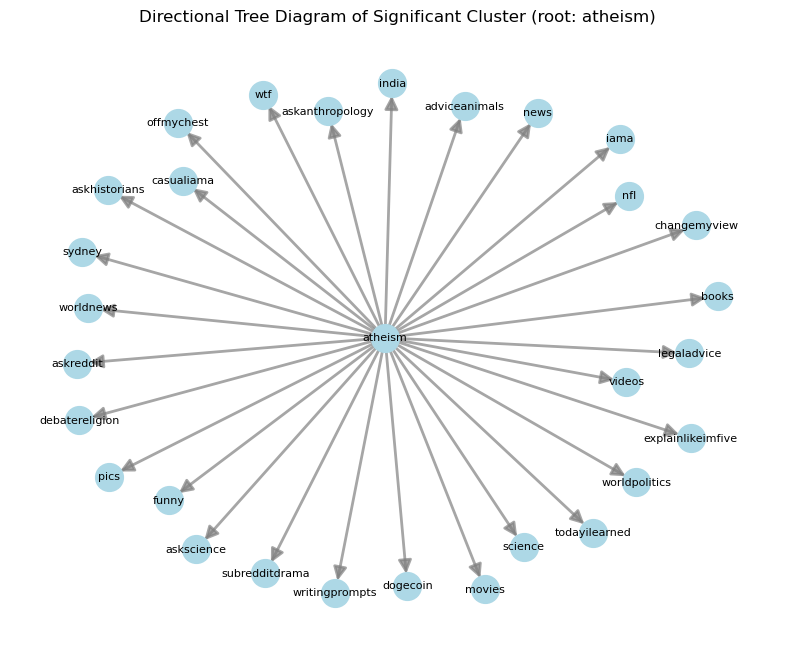

In [6]:
import matplotlib.pyplot as plt

def visualize_directional_tree_from_cluster(G, cluster_nodes, root=None, max_nodes=30):
    # Extract the directed subgraph for the cluster
    cluster_nodes = list(cluster_nodes)
    subG = G.subgraph(cluster_nodes)
    # Choose a root if not provided
    if root is None:
        root = cluster_nodes[0]
    # Build a BFS tree from the root
    tree = nx.bfs_tree(subG, root)
    # Limit the number of nodes for clarity
    nodes_to_draw = list(tree.nodes)[:max_nodes]
    tree = tree.subgraph(nodes_to_draw)
    # Draw the tree
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(tree, seed=42)
    nx.draw_networkx_nodes(tree, pos, node_color='lightblue', node_size=400)
    nx.draw_networkx_labels(tree, pos, font_size=8)
    nx.draw_networkx_edges(tree, pos, edge_color='gray', arrows=True, arrowsize=20, width=2, alpha=0.7)
    plt.title(f"Directional Tree Diagram of Significant Cluster (root: {root})")
    plt.axis('off')
    plt.show()

# Visualize the largest cluster as a directed tree
visualize_directional_tree_from_cluster(G, largest_cluster, root=None, max_nodes=30)


In [10]:
import numpy as np
import networkx as nx
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def compute_significant_clusters(G, node_sample_size=200, top_k=3):
    # 1. Subsample nodes for tractability
    nodes = list(G.nodes)[:node_sample_size]
    subG = G.subgraph(nodes)
    # 2. Compute symmetric shortest-path distance matrix (1/weight)
    distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
    for i, u in enumerate(nodes):
        lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d['weight'])
        for j, v in enumerate(nodes):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    # 3. Persistent homology (H0)
    diagrams = ripser(distance_matrix, distance_matrix=True)['dgms']
    H0 = diagrams[0]
    persistences = H0[:,1] - H0[:,0]
    top_indices = np.argsort(persistences)[-top_k:]
    # 4. For each significant cluster, get the nodes just before merging
    clusters = []
    for idx in top_indices:
        death_value = H0[idx, 1]
        threshold = death_value - 1e-8
        adjacency = (distance_matrix <= threshold).astype(int)
        G_thresh = nx.Graph()
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                if adjacency[i, j]:
                    G_thresh.add_edge(nodes[i], nodes[j])
        components = list(nx.connected_components(G_thresh))
        # Find the component that contains the "birth" node
        birth_node_idx = idx
        birth_node = nodes[birth_node_idx] if birth_node_idx < len(nodes) else nodes[0]
        for comp in components:
            if birth_node in comp:
                clusters.append(sorted(list(comp)))
                break
    return clusters

def visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=30):
    # Extract the directed subgraph for the cluster
    cluster_nodes = list(cluster_nodes)
    subG = G.subgraph(cluster_nodes)
    # Choose a root if not provided
    if root is None:
        root = cluster_nodes[0]
    # Build a BFS tree from the root
    tree = nx.bfs_tree(subG, root)
    # Limit the number of nodes for clarity
    nodes_to_draw = list(tree.nodes)[:max_nodes]
    tree = tree.subgraph(nodes_to_draw)
    # Draw the tree
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(tree, seed=42)
    nx.draw_networkx_nodes(tree, pos, node_color='lightblue', node_size=400)
    nx.draw_networkx_labels(tree, pos, font_size=8)
    nx.draw_networkx_edges(tree, pos, edge_color='gray', arrows=True, arrowsize=20, width=2, alpha=0.7)
    plt.title(f"Directional Tree Diagram of Cluster (root: {root})")
    plt.axis('off')
    plt.show()

def interactive_cluster_explorer(G, node_sample_size=200, top_k=3, max_tree_nodes=30):
    clusters = compute_significant_clusters(G, node_sample_size=node_sample_size, top_k=top_k)
    cluster_options = [f"Cluster {i+1} (size {len(c)})" for i, c in enumerate(clusters)]
    dropdown = widgets.Dropdown(options=cluster_options, description='Cluster:')
    output = widgets.Output()
    
    def on_change(change):
        with output:
            clear_output(wait=True)
            idx = cluster_options.index(change['new'])
            cluster_nodes = clusters[idx]
            print(f"Subreddits in {change['new']}:")
            print(cluster_nodes)
            visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=max_tree_nodes)
    
    dropdown.observe(on_change, names='value')
    display(dropdown, output)
    # Trigger initial display
    dropdown.value = cluster_options[0]

# Example usage:
# interactive_cluster_explorer(G, node_sample_size=200, top_k=3, max_tree_nodes=30)


In [ ]:
interactive_cluster_explorer(G, node_sample_size=500, top_k=5, max_tree_nodes=30)


Dropdown(description='Cluster:', options=('Cluster 1 (size 417)', 'Cluster 2 (size 500)', 'Cluster 3 (size 500…

Output()

In [15]:
import numpy as np
import networkx as nx
from ripser import ripser
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def compute_significant_clusters(G, node_sample_size=200, top_k=3):
    nodes = list(G.nodes)[:node_sample_size]
    subG = G.subgraph(nodes)
    # Compute symmetric shortest-path distance matrix (1/weight)
    distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
    for i, u in enumerate(nodes):
        lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d['weight'])
        for j, v in enumerate(nodes):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    # Persistent homology (H0)
    diagrams = ripser(distance_matrix, distance_matrix=True)['dgms']
    H0 = diagrams[0]
    persistences = H0[:,1] - H0[:,0]
    top_indices = np.argsort(persistences)[-top_k:]
    clusters = []
    cluster_labels = []
    for idx in top_indices:
        death_value = H0[idx, 1]
        threshold = death_value - 1e-8
        adjacency = (distance_matrix <= threshold).astype(int)
        G_thresh = nx.Graph()
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                if adjacency[i, j]:
                    G_thresh.add_edge(nodes[i], nodes[j])
        components = list(nx.connected_components(G_thresh))
        # Find the component that contains the node corresponding to this feature's birth
        # If not found, just take the largest component
        birth_node_idx = idx if idx < len(nodes) else 0
        birth_node = nodes[birth_node_idx]
        found = False
        for comp in components:
            if birth_node in comp:
                clusters.append(sorted(list(comp)))
                cluster_labels.append(f"Cluster {len(clusters)} (size {len(comp)})")
                found = True
                break
        if not found and components:
            clusters.append(sorted(list(max(components, key=len))))
            cluster_labels.append(f"Cluster {len(clusters)} (size {len(clusters[-1])})")
    return clusters, cluster_labels

def visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=30):
    cluster_nodes = list(cluster_nodes)
    subG = G.subgraph(cluster_nodes)
    if not subG.nodes:
        print("No nodes to display in this cluster.")
        return
    if root is None or root not in subG.nodes:
        root = cluster_nodes[0]
    tree = nx.bfs_tree(subG, root)
    nodes_to_draw = list(tree.nodes)[:max_nodes]
    tree = tree.subgraph(nodes_to_draw)
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(tree, seed=42)
    nx.draw_networkx_nodes(tree, pos, node_color='lightblue', node_size=400)
    nx.draw_networkx_labels(tree, pos, font_size=8)
    nx.draw_networkx_edges(tree, pos, edge_color='gray', arrows=True, arrowsize=20, width=2, alpha=0.7)
    plt.title(f"Directional Tree Diagram of Cluster (root: {root})")
    plt.axis('off')
    plt.show()

def interactive_cluster_explorer(G, node_sample_size=200, top_k=3, max_tree_nodes=30):
    clusters, cluster_labels = compute_significant_clusters(G, node_sample_size=node_sample_size, top_k=top_k)
    dropdown = widgets.Dropdown(options=list(zip(cluster_labels, range(len(clusters)))), description='Cluster:')
    output = widgets.Output()
    
    def on_change(change):
        with output:
            clear_output(wait=True)
            idx = change['new']
            cluster_nodes = clusters[idx]
            print(f"Subreddits in {cluster_labels[idx]}:")
            print(cluster_nodes)
            visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=max_tree_nodes)
    
    dropdown.observe(lambda change: on_change(change) if change['name'] == 'value' and change['type'] == 'change' else None, names='value')
    display(dropdown, output)
    # Trigger initial display
    dropdown.value = 0

# Example usage:
# interactive_cluster_explorer(G, node_sample_size=200, top_k=3, max_tree_nodes=30)


In [17]:
import numpy as np
import networkx as nx
from ripser import ripser
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def compute_clusters_at_threshold(G, node_sample_size=200, distance_threshold=1.0):
    nodes = list(G.nodes)[:node_sample_size]
    subG = G.subgraph(nodes)
    # Compute symmetric shortest-path distance matrix (1/weight)
    distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
    for i, u in enumerate(nodes):
        lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d['weight'])
        for j, v in enumerate(nodes):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    # Threshold the distance matrix
    adjacency = (distance_matrix <= distance_threshold).astype(int)
    G_thresh = nx.Graph()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if adjacency[i, j]:
                G_thresh.add_edge(nodes[i], nodes[j])
    clusters = [sorted(list(comp)) for comp in nx.connected_components(G_thresh)]
    return clusters

def visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=30):
    cluster_nodes = list(cluster_nodes)
    subG = G.subgraph(cluster_nodes)
    if not subG.nodes:
        print("No nodes to display in this cluster.")
        return
    if root is None or root not in subG.nodes:
        root = cluster_nodes[0]
    tree = nx.bfs_tree(subG, root)
    nodes_to_draw = list(tree.nodes)[:max_nodes]
    tree = tree.subgraph(nodes_to_draw)
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(tree, seed=42)
    nx.draw_networkx_nodes(tree, pos, node_color='lightblue', node_size=400)
    nx.draw_networkx_labels(tree, pos, font_size=8)
    nx.draw_networkx_edges(tree, pos, edge_color='gray', arrows=True, arrowsize=20, width=2, alpha=0.7)
    plt.title(f"Directional Tree Diagram of Cluster (root: {root})")
    plt.axis('off')
    plt.show()

def interactive_cluster_explorer_sensitive(G, node_sample_size=200, max_tree_nodes=30):
    # Compute the distance matrix once for efficiency
    nodes = list(G.nodes)[:node_sample_size]
    subG = G.subgraph(nodes)
    distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
    for i, u in enumerate(nodes):
        lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d['weight'])
        for j, v in enumerate(nodes):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    # Widget for threshold
    finite_distances = distance_matrix[np.isfinite(distance_matrix)]
    min_dist = np.min(finite_distances)
    max_dist = np.max(finite_distances)
    threshold_slider = widgets.FloatSlider(
        value=min_dist + (max_dist - min_dist) / 4,
        min=min_dist,
        max=max_dist,
        step=(max_dist - min_dist) / 100,
        description='Dist. Threshold:',
        continuous_update=False
    )
    cluster_dropdown = widgets.Dropdown(description='Cluster:')
    output = widgets.Output()

    def update_clusters(change):
        threshold = threshold_slider.value
        adjacency = (distance_matrix <= threshold).astype(int)
        G_thresh = nx.Graph()
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                if adjacency[i, j]:
                    G_thresh.add_edge(nodes[i], nodes[j])
        clusters = [sorted(list(comp)) for comp in nx.connected_components(G_thresh)]
        cluster_options = [f"Cluster {i+1} (size {len(c)})" for i, c in enumerate(clusters)]
        cluster_dropdown.options = list(zip(cluster_options, range(len(clusters))))
        cluster_dropdown.value = 0
        cluster_dropdown.clusters = clusters

    def show_cluster(change):
        with output:
            clear_output(wait=True)
            idx = cluster_dropdown.value
            clusters = getattr(cluster_dropdown, 'clusters', [])
            if not clusters:
                print("No clusters found.")
                return
            cluster_nodes = clusters[idx]
            print(f"Subreddits in {cluster_dropdown.options[idx][0]}:")
            print(cluster_nodes)
            visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=max_tree_nodes)

    threshold_slider.observe(update_clusters, names='value')
    cluster_dropdown.observe(show_cluster, names='value')

    display(threshold_slider, cluster_dropdown, output)
    # Initialize
    update_clusters(None)
    show_cluster(None)

# Usage:
# interactive_cluster_explorer_sensitive(G, node_sample_size=200, max_tree_nodes=30)


In [ ]:
interactive_cluster_explorer(G, node_sample_size=500, top_k=5, max_tree_nodes=30)

Dropdown(description='Cluster:', options=(('Cluster 1 (size 417)', 0), ('Cluster 2 (size 500)', 1), ('Cluster …

Output()

In [19]:
import numpy as np
import networkx as nx
from ripser import ripser
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def compute_significant_clusters_by_death(G, node_sample_size=200, min_death=0.3):
    nodes = list(G.nodes)[:node_sample_size]
    subG = G.subgraph(nodes)
    # Compute symmetric shortest-path distance matrix (1/weight)
    distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
    for i, u in enumerate(nodes):
        lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d['weight'])
        for j, v in enumerate(nodes):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    # Persistent homology (H0)
    diagrams = ripser(distance_matrix, distance_matrix=True)['dgms']
    H0 = diagrams[0]
    # Only keep features with death > min_death and finite death
    valid = np.where((H0[:,1] > min_death) & np.isfinite(H0[:,1]))[0]
    clusters = []
    cluster_labels = []
    death_times = []
    for idx in valid:
        death_value = H0[idx, 1]
        threshold = death_value - 1e-8
        adjacency = (distance_matrix <= threshold).astype(int)
        G_thresh = nx.Graph()
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                if adjacency[i, j]:
                    G_thresh.add_edge(nodes[i], nodes[j])
        components = list(nx.connected_components(G_thresh))
        # Find the component that contains the node corresponding to this feature's birth
        birth_node_idx = idx if idx < len(nodes) else 0
        birth_node = nodes[birth_node_idx]
        found = False
        for comp in components:
            if birth_node in comp:
                clusters.append(sorted(list(comp)))
                cluster_labels.append(f"Death={death_value:.3f}, size={len(comp)}")
                death_times.append(death_value)
                found = True
                break
        if not found and components:
            clusters.append(sorted(list(max(components, key=len))))
            cluster_labels.append(f"Death={death_value:.3f}, size={len(clusters[-1])}")
            death_times.append(death_value)
    return clusters, cluster_labels, death_times

def visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=30):
    cluster_nodes = list(cluster_nodes)
    subG = G.subgraph(cluster_nodes)
    if not subG.nodes:
        print("No nodes to display in this cluster.")
        return
    if root is None or root not in subG.nodes:
        root = cluster_nodes[0]
    tree = nx.bfs_tree(subG, root)
    nodes_to_draw = list(tree.nodes)[:max_nodes]
    tree = tree.subgraph(nodes_to_draw)
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(tree, seed=42)
    nx.draw_networkx_nodes(tree, pos, node_color='lightblue', node_size=400)
    nx.draw_networkx_labels(tree, pos, font_size=8)
    nx.draw_networkx_edges(tree, pos, edge_color='gray', arrows=True, arrowsize=20, width=2, alpha=0.7)
    plt.title(f"Directional Tree Diagram of Cluster (root: {root})")
    plt.axis('off')
    plt.show()

def interactive_cluster_explorer_by_death(G, node_sample_size=200, min_death=0.3, max_tree_nodes=30):
    clusters, cluster_labels, death_times = compute_significant_clusters_by_death(
        G, node_sample_size=node_sample_size, min_death=min_death
    )
    if not clusters:
        print(f"No clusters found with death time after {min_death}.")
        return
    dropdown = widgets.Dropdown(options=list(zip(cluster_labels, range(len(clusters)))), description='Cluster:')
    output = widgets.Output()
    
    def on_change(change):
        with output:
            clear_output(wait=True)
            idx = change['new']
            cluster_nodes = clusters[idx]
            print(f"Subreddits in {cluster_labels[idx]}:")
            print(cluster_nodes)
            visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=max_tree_nodes)
    
    dropdown.observe(lambda change: on_change(change) if change['name'] == 'value' and change['type'] == 'change' else None, names='value')
    display(dropdown, output)
    # Trigger initial display
    dropdown.value = 0

# Example usage:
# interactive_cluster_explorer_by_death(G, node_sample_size=200, min_death=0.3, max_tree_nodes=30)


In [21]:
import numpy as np
import networkx as nx
from ripser import ripser
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def compute_significant_clusters_by_death(G, node_sample_size=200, min_death=0.3, top_k=5):
    nodes = list(G.nodes)[:node_sample_size]
    subG = G.subgraph(nodes)
    # Compute symmetric shortest-path distance matrix (1/weight)
    distance_matrix = np.full((len(nodes), len(nodes)), np.inf)
    for i, u in enumerate(nodes):
        lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d['weight'])
        for j, v in enumerate(nodes):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    # Persistent homology (H0)
    diagrams = ripser(distance_matrix, distance_matrix=True)['dgms']
    H0 = diagrams[0]
    persistences = H0[:,1] - H0[:,0]
    # Only keep features with death > min_death and finite death
    valid = np.where((H0[:,1] > min_death) & np.isfinite(H0[:,1]))[0]
    # Sort by persistence (descending)
    valid = valid[np.argsort(persistences[valid])[::-1]]
    # Limit to top_k
    valid = valid[:top_k]
    clusters = []
    cluster_labels = []
    death_times = []
    for idx in valid:
        death_value = H0[idx, 1]
        threshold = death_value - 1e-8
        adjacency = (distance_matrix <= threshold).astype(int)
        G_thresh = nx.Graph()
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                if adjacency[i, j]:
                    G_thresh.add_edge(nodes[i], nodes[j])
        components = list(nx.connected_components(G_thresh))
        # Find the component that contains the birth node
        birth_node_idx = idx if idx < len(nodes) else 0
        birth_node = nodes[birth_node_idx]
        found = False
        for comp in components:
            if birth_node in comp:
                clusters.append(sorted(list(comp)))
                cluster_labels.append(f"Death={death_value:.3f}, size={len(comp)}")
                death_times.append(death_value)
                found = True
                break
        if not found and components:
            clusters.append(sorted(list(max(components, key=len))))
            cluster_labels.append(f"Death={death_value:.3f}, size={len(clusters[-1])}")
            death_times.append(death_value)
    return clusters, cluster_labels, death_times

def visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=30):
    cluster_nodes = list(cluster_nodes)
    subG = G.subgraph(cluster_nodes)
    if not subG.nodes:
        print("No nodes to display in this cluster.")
        return
    if root is None or root not in subG.nodes:
        root = cluster_nodes[0]
    # Build a BFS tree from the root, but include all nodes in the cluster
    tree = nx.bfs_tree(subG, root)
    # If the tree is too small, just use the full subgraph
    if len(tree.nodes) < min(max_nodes, len(cluster_nodes)):
        tree = subG
    # Limit the number of nodes for clarity
    nodes_to_draw = list(tree.nodes)[:max_nodes]
    tree = tree.subgraph(nodes_to_draw)
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(tree, seed=42)
    nx.draw_networkx_nodes(tree, pos, node_color='lightblue', node_size=400)
    nx.draw_networkx_labels(tree, pos, font_size=8)
    nx.draw_networkx_edges(tree, pos, edge_color='gray', arrows=True, arrowsize=20, width=2, alpha=0.7)
    plt.title(f"Directional Tree Diagram of Cluster (root: {root})")
    plt.axis('off')
    plt.show()

def interactive_cluster_explorer_by_death(G, node_sample_size=200, min_death=0.3, top_k=5, max_tree_nodes=30):
    clusters, cluster_labels, death_times = compute_significant_clusters_by_death(
        G, node_sample_size=node_sample_size, min_death=min_death, top_k=top_k
    )
    if not clusters:
        print(f"No clusters found with death time after {min_death}.")
        return
    dropdown = widgets.Dropdown(options=list(zip(cluster_labels, range(len(clusters)))), description='Cluster:')
    output = widgets.Output()
    
    def on_change(change):
        with output:
            clear_output(wait=True)
            idx = change['new']
            cluster_nodes = clusters[idx]
            print(f"Subreddits in {cluster_labels[idx]}:")
            print(cluster_nodes)
            visualize_directional_tree(G, cluster_nodes, root=None, max_nodes=max_tree_nodes)
    
    dropdown.observe(lambda change: on_change(change) if change['name'] == 'value' and change['type'] == 'change' else None, names='value')
    display(widgets.HBox([
        widgets.Label("Number of clusters to show:"),
        widgets.IntSlider(value=top_k, min=1, max=20, step=1, description='top_k', continuous_update=False)
    ]), dropdown, output)
    
    # Add interactivity for top_k
    def update_top_k(change):
        new_top_k = change['new']
        clusters2, cluster_labels2, _ = compute_significant_clusters_by_death(
            G, node_sample_size=node_sample_size, min_death=min_death, top_k=new_top_k
        )
        if not clusters2:
            dropdown.options = []
            with output:
                clear_output(wait=True)
                print(f"No clusters found with death time after {min_death}.")
            return
        dropdown.options = list(zip(cluster_labels2, range(len(clusters2))))
        dropdown.value = 0
        # Store new clusters for the dropdown
        nonlocal clusters, cluster_labels
        clusters = clusters2
        cluster_labels = cluster_labels2

    # Find the IntSlider widget and connect it
    int_slider = None
    for w in widgets.Widget.widgets.values():
        if isinstance(w, widgets.IntSlider) and w.description == 'top_k':
            int_slider = w
            break
    if int_slider:
        int_slider.observe(update_top_k, names='value')
    
    # Trigger initial display
    dropdown.value = 0

# Example usage:
# interactive_cluster_explorer_by_death(G, node_sample_size=200, min_death=0.3, top_k=5, max_tree_nodes=30)


In [ ]:
interactive_cluster_explorer_by_death(G, node_sample_size=2000, min_death=0.3, top_k=5, max_tree_nodes=50)

Dropdown(description='Cluster:', options=(('Death=1.000, size=2', 0), ('Death=1.000, size=1500', 1), ('Death=1…

Output()